In [1]:
import sys
sys.path.append('../')
from Roma import graphbuilder_v2
from availability_estimation import *
import corridor_builder
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

/Users/polina/Desktop/github/transport_frames/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Транспортные корридоры

In [2]:
lo_polygon = ox.geocode_to_gdf('R176095', by_osmid=True).to_crs(epsg=32636)
spb_polygon = ox.geocode_to_gdf('R337422', by_osmid=True).to_crs(epsg=32636).buffer(3000)
city = lo_polygon.union(spb_polygon).to_crs(epsg=4326) #  get lo polygon

russia = ox.geocode_to_gdf("Russia") #  get border of the country

regions = gpd.read_file('russia.geojson') #  get regions
regions = regions[regions['ISO3166-2']!='RU-CHU']
regions = regions.to_crs(city.crs)

In [ ]:
citygraph = graphbuilder_v2.get_graph_from_polygon(city, crs=32636,country_polygon=russia)
carcas = graphbuilder_v2.get_carcas(citygraph,regions,city)

In [5]:
n,e = momepy.nx_to_gdf(carcas)
n,e = corridor_builder.weigh_roads(carcas)

/Users/polina/Desktop/github/transport_frames/Polina/corridor_builder.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.04]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  n.loc[(n['nodeID']==path[j]),'weight']+= weight
/Users/polina/Desktop/github/transport_frames/Polina/corridor_builder.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.04]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  e.loc[(e['node_start'] == path[j]) & (e['node_end'] == path[j+1]), 'weight'] +=weight


In [6]:
n.to_crs(3857,inplace=True)
e.to_crs(3857,inplace=True)

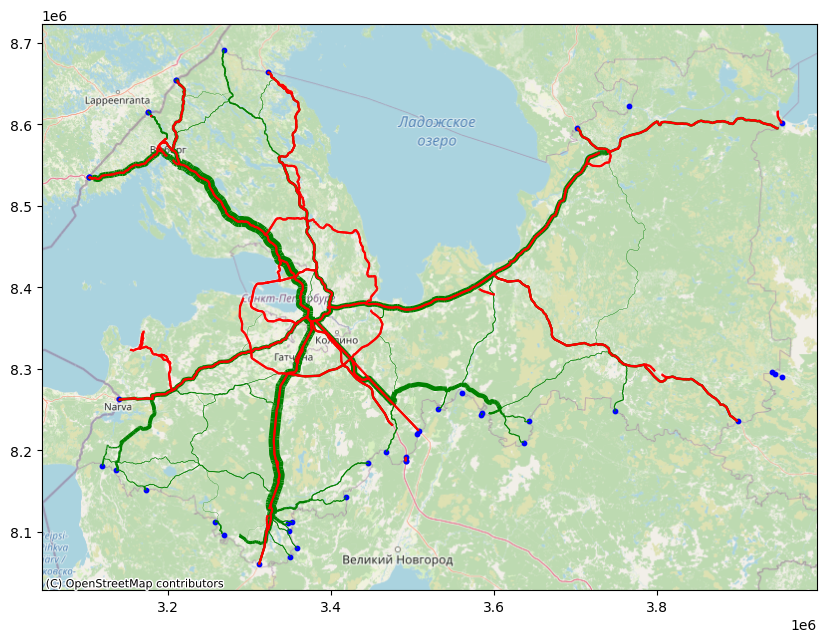

In [7]:

e['normalized_weight'] = e['weight'] / e['weight'].max()

fig, ax = plt.subplots(figsize=(10, 10))
e.plot(ax=ax, linewidth=e['normalized_weight'] * 8, color='green')
e[e['reg']==1].to_crs(epsg=3857).plot(ax=ax, color='red')
n[n['exit'] == 1].to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=10)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()


###todo положить атрибут вес в граф
положить атррибуты в годы

посчитать доступность

добавить условия в оценку

убрать из оценки эджи

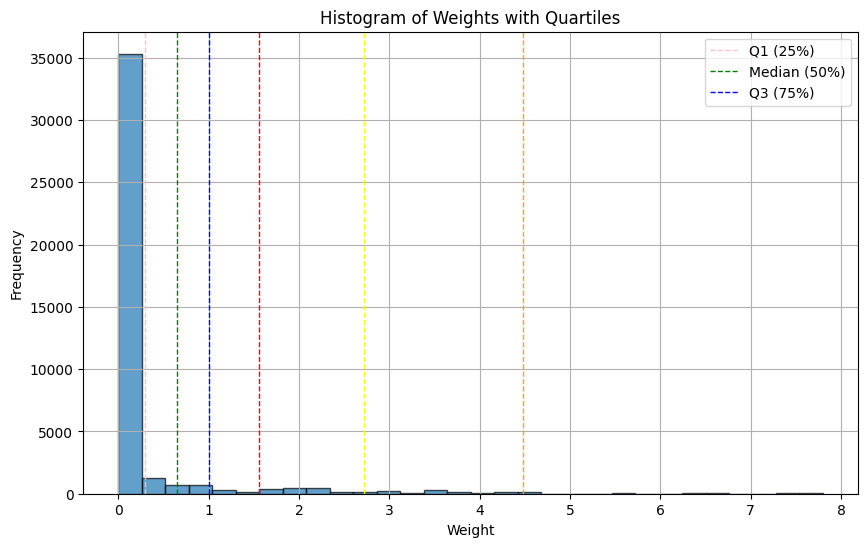

In [11]:
quartiles = e[e['weight']!=0]['weight'].quantile([0.2,0.4,0.5,0.6, 0.8,0.95])
plt.figure(figsize=(10, 6))
plt.hist(e['weight'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(quartiles[0.2], color='pink', linestyle='dashed', linewidth=1)
plt.axvline(quartiles[0.4], color='g', linestyle='dashed', linewidth=1)
plt.axvline(quartiles[0.5], color='b', linestyle='dashed', linewidth=1)

plt.axvline(quartiles[0.6], color='r', linestyle='dashed', linewidth=1)
plt.axvline(quartiles[0.8], color='yellow', linestyle='dashed', linewidth=1)
plt.axvline(quartiles[0.95], color='orange', linestyle='dashed', linewidth=1)

plt.title('Histogram of Weights with Quartiles')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.legend(['Q1 (25%)', 'Median (50%)', 'Q3 (75%)'])
plt.grid(True)
plt.show()

In [16]:
nodes = n
nodes[nodes['weight'] > np.percentile(nodes[nodes['weight'] != 0]['weight'], 60)]

,reg_1,reg_2,x,y,nodeID,border_region,ref_type,ref,exit,exit_country,geometry,weight,normalized_weight
32,True,True,316852.899705,6.503769e+06,32,NaN,NaN,None,NaN,NaN,POINT (3322300.959 8102008.378),6.90,0.561
35,True,False,316957.611043,6.503914e+06,35,NaN,NaN,None,NaN,NaN,POINT (3322488.365 8102295.942),6.90,0.561
36,True,False,316733.361446,6.503590e+06,36,NaN,NaN,None,NaN,NaN,POINT (3322088.183 8101655.658),6.90,0.561
42,True,True,314435.502345,6.493910e+06,42,NaN,NaN,None,NaN,NaN,POINT (3318570.431 8082906.116),2.82,0.229
44,True,False,314439.826184,6.493939e+06,44,NaN,NaN,None,NaN,NaN,POINT (3318576.053 8082962.052),2.82,0.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22950,True,False,327962.280598,6.621243e+06,22950,NaN,NaN,None,NaN,NaN,POINT (3333257.847 8331816.047),2.87,0.233
22951,True,False,328060.953197,6.621283e+06,22951,NaN,NaN,None,NaN,NaN,POINT (3333449.072 8331903.823),2.87,0.233
22952,True,False,325838.709825,6.620400e+06,22952,NaN,NaN,None,NaN,NaN,POINT (3329142.232 8329954.211),2.87,0.233
22953,True,False,327863.790294,6.621205e+06,22953,NaN,NaN,None,NaN,NaN,POINT (3333066.778 8331732.815),2.87,0.233


In [ ]:
e[e['weight']>quartiles[0.6]].explore()

------